In [1036]:
import math
import numpy as np
from numba import cuda
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [1037]:
@cuda.jit
def calculate_drift(m):
    i, j = cuda.grid(2)
    if m[i,j] > .1:
        divisor = 5
        if i == 0 or m[i-1,j] > m[i,j]:
            divisor -= 1
        if j == 0 or m[i,j-1] > m[i,j]:
            divisor -= 1
        if j == size - 1 or m[i,j+1] > m[i,j]:
            divisor -= 1
        if i == size - 1 or m[i+1,j] > m[i,j]:
            divisor -= 1

        # if (i == size - 1 and j == size - 1) or m[i+1,j+1] > m[i,j]:
        #     divisor -= 1
        # if (i == 0 and j == 0) or m[i-1,j-1] > m[i,j]:
        #     divisor -= 1
        # if (i == 0 and j == size - 1) or m[i-1,j+1] > m[i,j]:
        #     divisor -= 1
        # if (j == 0 and i == size - 1) or m[i+1,j-1] > m[i,j]:
        #     divisor -= 1

        if divisor == 0:
            return

        loss_from_center = 0

        if i > 0 and m[i-1,j] < m[i,j]:
            exchange = (m[i,j] - m[i-1, j]) / divisor
            m[i-1,j] += exchange
            loss_from_center += exchange


        if j > 0 and m[i,j-1] < m[i,j]:
            exchange = (m[i,j] - m[i, j-1]) / divisor
            m[i,j-1] += exchange
            loss_from_center += exchange


        if j < size - 1 and m[i,j+1] < m[i,j]:
            exchange = (m[i,j] - m[i, j+1]) / divisor
            m[i,j+1] += exchange
            loss_from_center += exchange


        if i < size - 1 and m[i+1,j] < m[i,j]:
            exchange = (m[i,j] - m[i+1, j]) / divisor
            m[i+1,j] += exchange
            loss_from_center += exchange

        # if j < size - 1 and i < size - 1 and m[i+1,j+1] < m[i,j]:
        #     m[i+1,j+1] += m[i,j] / divisor
        # if i > 0 and j > 0 and m[i-1,j-1] < m[i,j]:
        #     m[i-1,j-1] += m[i,j] / divisor
        # if i > 0 and j < size - 1 and m[i-1,j+1] < m[i,j]:
        #     m[i-1,j+1] += m[i,j] / divisor
        # if j > 0 and i < size - 1 and m[i+1,j-1] < m[i,j]:
        #     m[i+1,j-1] += m[i,j] / divisor


        m[i,j] -= loss_from_center
    else:
        m[i,j] = .1


In [1038]:
size = 16*100

In [1039]:
m = np.zeros((size, size))
m[int(size / 2), int(size / 2)] = 10

In [1040]:
# 16x16 threads per block.
bs = 16
# Number of blocks in the grid.
bpg = math.ceil(size / bs)
# We prepare the GPU function.
f = calculate_drift[(bpg, bpg), (bs, bs)]

In [1041]:
m_gpu = cuda.to_device(m)

In [1042]:
%%timeit
for x in range(10000):
    f(m_gpu)


4.25 s ± 46.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [1043]:
m = m_gpu.copy_to_host()

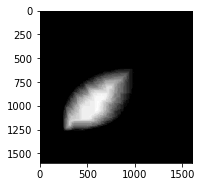

In [1044]:
fig = plt.figure()
ax2 = fig.add_subplot(122)
ax2.imshow(m, interpolation='nearest', cmap=cm.Greys_r)

plt.show()

In [1045]:
# add a test that the total contents of the array is equal to the input